Juuso Eronen

Victor Ramirez

Huayi Wu


Please read though the entire project before starting!

# Homework 3 - Making Superbugs using Agent based Modeling.

In this homework we are going to build an agent based model to simulate the evolution of bacteria to become resistant to antibiotics.   Please watch the following video.  Our goal is to build a simulation that reconstructs this real world experiment. 

http://www.the-scientist.com/?articles.view/articleNo/46993/title/Giant-Petri-Dish-Displays-Evolution-in-Space-and-Time/

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("yybsSqcB7mE",width=640,height=360)

### Project Components and Grading,

1. (5 points) Use git to manage your project. 
1. (5 points) Document all Assumptions
1. (30 points) Digital Evolution Code Development
1. (20 points) Create Visualization
1. (20 points) Testing Code
1. (20 points) Experimental Reproduction

As in the previous homework, you will be expected to split the work evenly between your teammates.  



----
# Part 1: (5 points) Use git to manage your projects
As in the previous homework, you will be expected to split the work evenly between your teammates.  
    * Create a private repository in github or gitlab and include your instructor as a member.  
    * Make sure you include a copy of this notebook in the top directory of your project folder.
    * Have every person in the group make commitments. 
    * This is how you will turn in your final project. 

**Question 1**: What is the command the instructors should use to download your project?

git clone git@gitlab.msu.edu:ramir193/HW3-Superbugs.git

----
# Part 2: (5 points) Document all Assumptions

To make this ABM work I would like you to build a system with the following assumptions.

1. Assume a random rectangular petri dish of N locations wide and M locations tall (ex 90 x 45).
1. Assume that each location on the board is given three (3) different types of anti-bacteria which each can have continuous values from min to max (ex. 0 to 1).
1. Assume that bacteria on the board do not move. 
1. Assume each bacteria has a genome sequence of three genes of continuous number (ex. 0 1) that provide immunity to the anti-bacteria. Each gene will correspond to one of the anti-bacterial elements deposited on the petri dish
1. Assume that at each iteration of the simulation each bacteria can randomly copy itself once to a random neighboring empty cell (up, down, left, or right). 
1. Assume that during the copy there is a chance of mutating (randomly selecting a new value) each gene by some mutation rate (ex. 20%). 
1. Assume that a bacteria will "die" if the value of it's gene does not contain resistance to anti-bacteria. For example, if the gene is a number less than the value of it's corresponding anti-bacteria it will die.

**NOTE:** Assumptions are very important.  Make sure you document any major changes, clarifications or deviations from the above.  Instead of asking your instructor for clarification, try looking at the end goal (simulate the petri dish experiment) and make your own clarification. There are many right answers.  Even if you make incorrect choices in assumptions I can give more partial credit if you document them properly. 

**Question 2**: What additional assumptions did you make for your project?  Did you need to modify or add to any of the above assumptions to make the problem more tractable?

1. Bacteria can't reproduce if there are no adjacent cells that are both on the board and do not already have bacteria living in them.

2. Antibacteria are uniformly scattered throughout the board unless the harvard distribution is used

----
# Part 3: (30 points)  Digital Evolution Code Development

As a group decide on what classes will be needed and create stub functions for your classes.  Distribute the work evenly between your group using GIT.  Note the following:

* I will expect to see stubbed versions of your project in GIT.  
* I will also expect many commitments to git so I can visualize your design process.
* Points will be given based on the ease of understanding and reading of your code. (Ex. Make sure you use DocStrings).

In [186]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random 

from IPython.display import display, clear_output
import time

class World():

    def get_harvard_antibac(self, col):
        bins = [0, 0.5, 0.75, 0.8, 0.9, 0.8, 0.75, 0.5, 0]
        bin_width = int(self.c / len(bins))
        index = int(col / bin_width)
        return [bins[index - 1]] * 3
    
    def get_uniform_antibac(self, col):
        return self.anti_b_lst
    
    def __init__(self, r = 20, c = 50, anti_b_lst = [], uniform = True):
        '''Initializes the world with the following attributes:
        r,c are rows and columns of the world
        anti_b_lst is a list of the strengths of the anti-bacteria, default is random
        unform decides whether the anti-bacteria is equally distributed
        '''
        self.r = r
        self.c = c
        # Use a uniform layer of antibacteria over the board
        if anti_b_lst == []:
            self.anti_b_lst = [random.uniform(0,1) for _ in range(0, 3)]
        else:
            self.anti_b_lst = anti_b_lst
            
        # Now we can conveniently alternate between the harvard distribution and a uniform layer
        if uniform:
            self.get_anti_bac = self.get_uniform_antibac
        else:
            self.get_anti_bac = self.get_harvard_antibac
            
        self.bac = {}
        self.bac_mat = np.zeros((r, c))
        
    def add_bacteria(self, num = 100, edges=False):
        '''populates (num) of bacteria onto world'''
        if edges:
            print("Placing bacteria on edges")
            # Don't bother checking for empties, assume this fill method
            # is only ever used to initialize the board
            def fill_block(from_col, to_col):
                for c in range(from_col, to_col):
                    for r in range(0, self.r):
                        self.bac[(r, c)] = Bacteria(c, r, self)
                        self.bac_mat[r][c] = 1
            # Calculate the number of columns we need to fill on each side
            cols = int(num / 2 / self.r)
            if cols < 1:
                raise Exception("Not enough bacteria to fill both edges!")
            fill_block(0, cols)
            fill_block(self.c - cols, self.c)
        else:
            # Check if there is any room on the board
            if len(self.bac) < self.r * self.c:
                empty_cells = []
                for r in range(0, self.r):
                    for c in range(0, self.c):
                        if not (r, c) in self.bac:
                            empty_cells.append((r, c))
                while num > 0 and len(empty_cells) > 0:
                    r, c = empty_cells.pop(random.randint(0, len(empty_cells) - 1))
                    num -= 1
                    self.bac[(r, c)] = Bacteria(c, r, self)
                    self.bac_mat[r][c] = 1
             
    def draw(self):
        '''Draws the bacteria matrix'''
        plt.imshow(self.bac_mat.T, origin='lower', aspect='equal', cmap='Greys')

In [187]:
class Bacteria():
    
    def __init__(self, x, y, grid, imm = []):
        '''Constructs instance of bacteria with the list imm as the immunities for each antibacteria, x & y as the locations'''
        if imm == []:
            self.imm = [random.uniform(0,1) for _ in range(0, 3)]
        else:
            self.imm = imm
        
        self.x = x
        self.y = y
        self.grid = grid
        
        
    def on_grid(self, x, y):
        '''Checks if coordinates given (x,y) are valid locations of the grid's dimensions (r,c)'''
        return x >= 0 and y >= 0 and x < self.grid.c and y < self.grid.r
    
    def copy(self):
        '''Copies attributes of self onto another instance of bacteria'''
        for x in range(self.x - 1, self.x + 2):
            for y in range(self.y - 1, self.y + 2):
                if not (x == self.x and y == self.y):
                    # Allow the bacteria to divide to the cell at x, y if the point
                    # is on the grid and no existing bacteria lives at x, y.
                    if self.on_grid(x, y) and self.grid.bac_mat[y][x] == 0:
                        offspring = Bacteria(x, y, self.grid, self.imm)
                        self.grid.bac_mat[y][x] = 1
                        return offspring
                    
        # If we get to this point, there were no free adjacent cells that are on the grid.
        return False
    
    def mutate(self, rate = 0.5):
        '''Each immunity gene has a [rate] chance of mutating'''
        self.imm = [random.uniform(0, 1) if random.random() < rate else current_val for current_val in self.imm]
        return self
        
    def die(self):
        '''Check if bacteria is immune to anti-bacteria; if bacteria doesn't pass check, it dies.'''   
        for i,j in zip(self.imm, self.grid.get_anti_bac(self.x)):
            if j > i:
                self.grid.bac_mat[self.y][self.x] = 0
                del self.grid.bac[(self.y, self.x)]
                return True
                
        return False
    
    def iterate(self, rate=0.2):
        '''
        1. Check for anti-bac to see if the bacteria should die
        2. If not, attempt to copy itself (cell division)
        3. If copied, apply mutation based on random chance
        '''
        
        if not self.die():
            child = self.copy()
            if child:
                self.grid.bac[(child.y, child.x)] = child
                child.mutate(rate)          
        

    def draw(self):
        '''Draws the bacteria and represents the colors based on the immunities'''
        rgb = self.imm
        plt.scatter(self.y, self.x, facecolors=rgb)    
    
    

**Question 3**: Although everyone is responsible for the entire homework.  How did you split up the work for this project?  (Hint: will I see this split if I look though your git logs)?

Juuso: Part 3, 6, one test for Part 5
Victor: Part 3, one test for Part 5
Huayi: Part 4, one test for Part 5

----
# Part 4: (20 points)  Create Visualization

A big part of this simulation is visualization of your results (see example below).  Much of your grade will be producing a visualization similar to the video at the beginning of this code.  Animate your visualization and include the following:

* Use colors indicating the level of antibiotics in the petri dish. Since there are three antibiotics you can use the Red, Green and Blue Channels to indicate the amount of each of the three antibiotics. 
* Use colors to differenciate the different types of the bugs. Since there are three genes you can use the Red, Green and Blue color channels to differentiate them. 
* Animate the simulation 

Bonus points if you can create a video (ex. mp4) and include it in your git repository or post it on YouTube. 

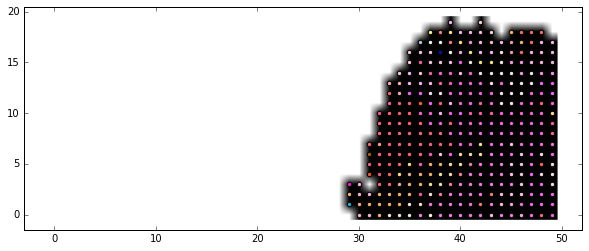

In [163]:
bac = []
r = 50
c = 20
pop = 40

world = World(r, c)
world.add_bacteria(pop)
    

fig, ax = plt.subplots(figsize=(10,5))
for i in range(20):
    world.draw()

    locs = list(world.bac.keys())
    for loc in locs:
        world.bac[loc].iterate()
    for key in world.bac:
        world.bac[key].draw()
    # Animaiton part (dosn't change)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.01)      # Sleep for a fraction of a second to allow animation to catch up
    


----
# Part 5: (20 points)  Testing Code

Make sure your code is well tested.  Please include at least 3 testing setup you used to help test and validate your code.  Include a print statement on what exactly each code is testing. 


I will be looking for completeness. Try to write at least one test for each class and each method in each class.  

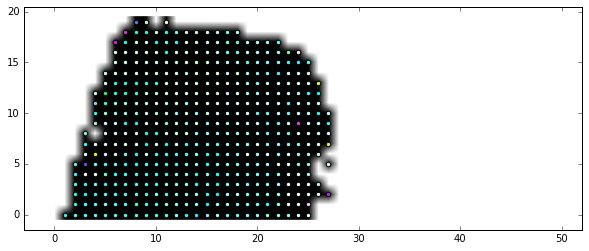

In [8]:
#Make antibacteria 1 weak and antibacteria 2 & 3 very strong
bac = []
r = 50
c = 20
pop = 100

world = World(r, c, [0.1,0.85,0.85])
world.add_bacteria(pop)

fig, ax = plt.subplots(figsize=(10,5))
for i in range(20):
    world.draw()

    locs = list(world.bac.keys())
    for loc in locs:
        world.bac[loc].iterate()
    for key in world.bac:
        world.bac[key].draw()
    # Animaiton part (dosn't change)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.01)      # Sleep for a fraction of a second to allow animation to catch up
    



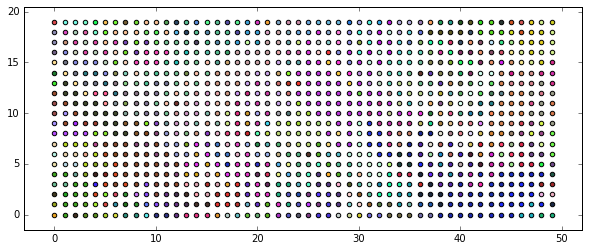

In [7]:
#Small population, weak anti-bacteria
bac = []
r = 50
c = 20
pop = 10

world = World(r, c, [0.1,0.1,0.1])
world.add_bacteria(pop)

fig, ax = plt.subplots(figsize=(10,5))
for i in range(20):
    world.draw()

    locs = list(world.bac.keys())
    for loc in locs:
        world.bac[loc].iterate()
    for key in world.bac:
        world.bac[key].draw()
    # Animaiton part (dosn't change)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.01)      # Sleep for a fraction of a second to allow animation to catch up
    



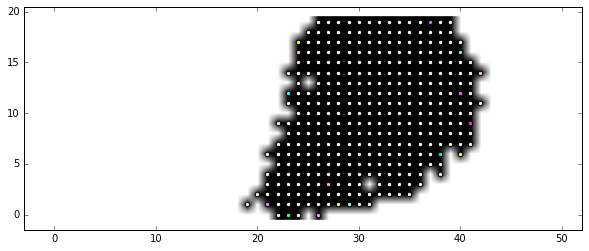

In [146]:
#All 3 anti-bacteria are strong
bac = []
r = 50
c = 20
pop = 300

world = World(r, c, [0.85,0.85,0.85])
world.add_bacteria(pop)

fig, ax = plt.subplots(figsize=(10,5))
for i in range(20):
    world.draw()

    locs = list(world.bac.keys())
    for loc in locs:
        world.bac[loc].iterate()
    for key in world.bac:
        world.bac[key].draw()
    # Animaiton part (dosn't change)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.01)      # Sleep for a fraction of a second to allow animation to catch up
    



In [ ]:
#Add more test code as needed

----
# Part 6: (20 points)  Experimental Reproduction

Set up and animate an experimental environment that closely matches the one show in the experiment from Harvard.  Obviously, since our environment is fully digital we have more control over the simulation so use color to provide the additional information that is not available to the researchers in the real world (ex. showing the different genes). Consider the following video:

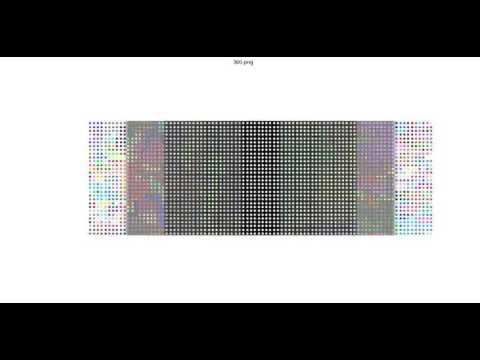

In [121]:
from IPython.display import YouTubeVideo
YouTubeVideo("p_wGHmNYE_0",width=640,height=360)

This video was created bwith the following settings:

* The bugs were inicialized in the first and last column of the petri dish with randomly generated bacteria 
* Equal amounts of all three antibiotics in 9 different bins using the following pattern:  
    | 0.0 | 0.50 | 0.75 | 0.80 | 0.90 | 0.80 | 0.75 | 0.5 | 0.0 |
* The cells copied with a mutation rate of 20% (i.e. there is a 20% chance each gene will randomly mutate during each copy).



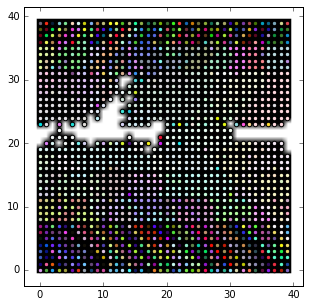

In [189]:
bac = []
r = 40
c = 40
pop = 160

world = World(r, c, uniform=False)
world.add_bacteria(pop, edges=True)

fig, ax = plt.subplots(figsize=(10,5))
for i in range(40):
    world.draw()

    locs = list(world.bac.keys())
    for loc in locs:
        world.bac[loc].iterate()
    for key in world.bac:
        world.bac[key].draw()
    # Animaiton part (dosn't change)
    clear_output(wait=True) # Clear output for dynamic display
    display(fig)            # Reset display
    fig.clear()             # Prevent overlapping and layered plots
    time.sleep(0.01)      # Sleep for a fraction of a second to allow animation to catch up

----

### Turning in your homework

Now, you need to submit this assignment by uploading this jupyter notebook file to the course Desire2Learn web page. Instructors will use this file to motivate downloading of your git repository and grading of your homework. This means we will have two identical copies of this notebook (one in D2L and one in your git repository).  Each group must only submit one file to D2L.   

Don't forget to add your names in the first cell.  Turn in all files using the "Homework assignments" folder, find the dropbox link for "HW3-Superbugs", and upload it there.